# Table of Content

1. [Data_Dictionary](#data-dictionary)
2. [Data_Preparation](#data-preparation)
3. [LSTM](#lstm)

# Data Dictionary

|Feature|Type|Description|
|---|---|---|
|Product_Code|*string*|The product name encoded|
|Warehouse|*string*|Warehouse ID|
|Product_Category|*string*|Product category of each product|
|Date|*string*|The date customer needs the product|
|Order_Demand|*string*|Order quantity|

In [1]:
# Import libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.random import seed
from numpy import array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.metrics import RSquare
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Read csv file and display shape.
df = pd.read_csv('../Data_Historical/df2.csv').iloc[:,1:]
df.shape

(924272, 5)

In [3]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,Whse_A,Category_006,2011-01-08,2
1,Product_1724,Whse_A,Category_003,2011-05-31,108
2,Product_1521,Whse_S,Category_019,2011-06-24,85000
3,Product_1521,Whse_S,Category_019,2011-06-24,7000
4,Product_1507,Whse_C,Category_019,2011-09-02,1250


# Data Preparation

In [4]:
# Set a seed.
tf.random.set_seed(12)

In [5]:
# Function to clean and resample order demand.
def get_product(data,product_code):
    df_init = data[data['Product_Code']==product_code]
    df_init['Date'] = pd.to_datetime(df_init['Date'])
    df_init = df_init.set_index('Date')
    df_out = pd.DataFrame(df_init['Order_Demand'].resample('W').sum())
    df_out.rename(columns={'Order_Demand':'demand'+'_'+product_code[-4:]}, inplace=True)
    return df_out
    

In [6]:
# split a univariate sequence
def split_sequence(sequence, n_steps):
 X, y = list(), list()
 
 for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
        break
    
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
 return array(X), array(y)

In [7]:
# Function to apply standard scaling to input.
def scale(X_train, X_test):
 # fit scaler
 scaler = StandardScaler()
 # Fit & transform train
 X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
 # Transform test
 X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
 return scaler, X_train, X_test

In [8]:
# Function to find the best epoch.
def find_best_epoch(history):
    model_history = pd.DataFrame(history).reset_index()
    model_history.rename(columns = {'index':'epoch'}, inplace=True)
    model_history['loss_diff'] = (model_history['loss'].map(lambda x: abs(x)) - model_history['val_loss'].map(lambda x: abs(x))).map(lambda x:abs(x))
    epoch = model_history[model_history['loss_diff']==model_history['loss_diff'].min()]
    epoch = int(epoch.iloc[0]['epoch'])
    return epoch

In [9]:
# Create dataframe of Product 1359.
prod_1359 = get_product(df, 'Product_1359')
prod_1359.head()

C:\Users\Zeonice\AppData\Local\Temp\ipykernel_10008\2577529180.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_init['Date'] = pd.to_datetime(df_init['Date'])


,demand_1359
Date,
2012-01-08,1226000
2012-01-15,1279000
2012-01-22,1401000
2012-01-29,1964000
2012-02-05,2591000


In [10]:
# define input sequence
raw_seq = prod_1359['demand_1359']

# choose a number of time steps
n_steps = 1

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [11]:
X.shape

(261, 1, 1)

In [12]:
# Train test split.
X_train = X[0:-12]
X_test = X[-12:]
y_train = y[0:-12]
y_test = y[-12:]

# Standard scale input.
scaler, X_train_scaled, X_test_scaled = scale(X_train, X_test)

# LSTM

In [15]:
all_rmse_lstm =list()
neuron_1 = list()
neuron_2 = list()
for n1 in [8,16,32,64,128]:
    for n2 in [8,16,32,64,128]:
        # define model
        model = Sequential()
        model.add(LSTM(n1, activation='relu', return_sequences=True,  input_shape=(n_steps, n_features)))#, dropout=0.5, 
        model.add(LSTM(n2, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=.001), loss='mse')

        es = EarlyStopping(patience = 30)
        # fit model
        lstm = model.fit(X_train_scaled, y_train, epochs=1000, verbose=0, validation_data=(X_test_scaled, y_test), batch_size=32, callbacks = [es]) 
    
        # Find the best epoch.
        best_epoch = find_best_epoch(lstm.history)
        print (best_epoch)
        # Demonstrate predictions.
        lstm = model.fit(X_train_scaled, y_train, epochs=best_epoch, verbose=0, validation_data=(X_test_scaled, y_test), batch_size=32)
        preds = model.predict(X_test_scaled[-4:])
    
        rmse_lstm = mean_squared_error(y_test[-4:], preds, squared=False)
        all_rmse_lstm.append(rmse_lstm)
        neuron_1.append(n1)
        neuron_2.append(n2)
        model.reset_states()
        print (f'n1: {n1}, n2: {n2}, rmse: {rmse_lstm}')
all_scores = pd.DataFrame({'neuron_1':neuron_1, 'neuron_2':neuron_2, 'rmse':all_rmse_lstm})

999
1/1 [==============================] - 0s 330ms/step
n1: 8, n2: 8, rmse: 593078.3166882666
999
1/1 [==============================] - 0s 290ms/step
n1: 8, n2: 16, rmse: 556946.4435935292
999
1/1 [==============================] - 0s 308ms/step
n1: 8, n2: 32, rmse: 840948.0397191496
999
1/1 [==============================] - 0s 294ms/step
n1: 8, n2: 64, rmse: 758481.4690713059
999
1/1 [==============================] - 0s 297ms/step
n1: 8, n2: 128, rmse: 1020139.7268684014
999
1/1 [==============================] - 0s 292ms/step
n1: 16, n2: 8, rmse: 653835.9752283514
999
1/1 [==============================] - 0s 286ms/step
n1: 16, n2: 16, rmse: 498026.1847285025
999
1/1 [==============================] - 0s 284ms/step
n1: 16, n2: 32, rmse: 900344.2522448206
999
1/1 [==============================] - 0s 286ms/step
n1: 16, n2: 64, rmse: 996489.9297188497
981
1/1 [==============================] - 0s 292ms/step
n1: 16, n2: 128, rmse: 979897.0422793829
999
1/1 [=========================

In [16]:
all_scores

,neuron_1,neuron_2,rmse
0,8,8,5.930783e+05
1,8,16,5.569464e+05
2,8,32,8.409480e+05
3,8,64,7.584815e+05
4,8,128,1.020140e+06
5,16,8,6.538360e+05
6,16,16,4.980262e+05
7,16,32,9.003443e+05
8,16,64,9.964899e+05
9,16,128,9.798970e+05


In [17]:
all_scores.to_csv('../Data_Historical/all_score.csv')

In [18]:
all_scores = pd.read_csv('../Data_Historical/all_score.csv')

In [19]:
# Best RMSE score is when First layer neuron = 16 and 2nd layet neuron = 9.
all_scores[all_scores['rmse']== all_scores['rmse'].min()]

,Unnamed: 0,neuron_1,neuron_2,rmse
6,6,16,16,498026.184729


Due to the stochastic nature of neural network, the result fluctuates everytime we run the same model with same parameter. After a few trials, I found that 64 neuron in the first layer and 32 neurons in the second layer gave the overall best results.

In [46]:
# set seed.
seed(1)
tf.random.set_seed(2)

# define model
#model.reset_states()
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True,  input_shape=(n_steps, n_features)))#, dropout=0.5, 
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=.001), loss='mse')

es = EarlyStopping(patience = 15)
# fit model
#lstm = model.fit(X_train_scaled, y_train, epochs=2000, verbose=0, validation_data=(X_test_scaled, y_test), batch_size=64, callbacks = [es]) 
    
# Find the best epoch.
#best_epoch = find_best_epoch(lstm.history)
#print (best_epoch)
    
# Demonstrate predictions.
#model.reset_states()
lstm = model.fit(X_train_scaled, y_train, epochs=800, verbose=0, batch_size=32, validation_data=(X_test_scaled, y_test)) # 
preds = model.predict(X_test_scaled[-4:])
    
rmse_lstm = mean_squared_error(y_test[-4:], preds, squared=False)
rmse_lstm

1/1 [==============================] - 0s 311ms/step


500553.20147063484

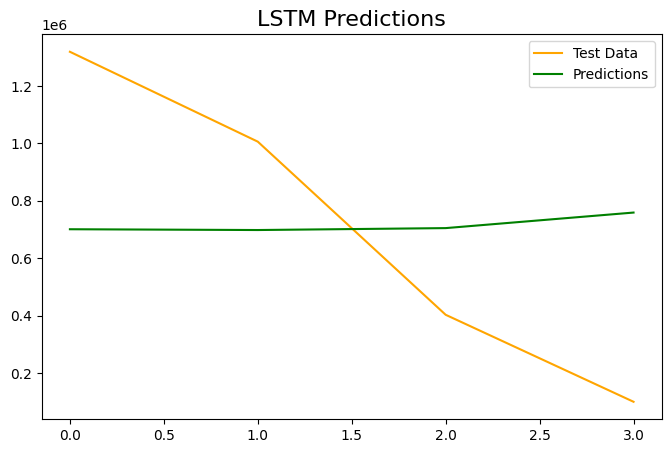

RMSE of LSTM model is: 500553.20147063484


In [47]:
# Plot data.
plt.figure(figsize=(8,5))

# Plot testing data.
plt.plot(pd.DataFrame(y_test[-4:]).index, pd.DataFrame(y_test[-4:]), color = 'orange')

# Plot predicted test values.
plt.plot(pd.DataFrame(y_test[-4:]).index, preds, color = 'green')
plt.legend(['Test Data','Predictions'])
plt.title(label = 'LSTM Predictions', fontsize=16)
plt.show();

rmse_lstm = mean_squared_error(y_test[-4:], preds, squared=False)
print (f'RMSE of LSTM model is: {rmse_lstm}')

Due to the stochastic nature of LSTM model, the predicted value is different at every run. Once we set a seed, we are able to have a closer range of predictions although not the exact same value. Although the RMSE value of this model is slightly higher than SARIMAX model, it is easier to implement as it does not need to find an exogenous feature.